In [18]:
import os
import h5py
import logomaker
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
params_file = '/home/drk/seqnn/data/models/v2/params_pred.json'
model_file = '/home/drk/seqnn/data/models/v2/f0c0/train/model0_best.h5'
targets_file = '/home/drk/seqnn/data/models/v2/f0c0/data0/targets.txt'
fasta_file = '%s/assembly/ucsc/hg38.fa' % os.environ['HG38']

In [3]:
rs_id = 'rs20417'
snp_dir = f'{rs_id}_out'

vcf_file = f'{rs_id}.vcf'
with open(vcf_file, 'w') as vcf_open:
    print('##fileformat=VCFv4.2', file=vcf_open)
    cols = ['chr1', '186681189', rs_id, 'C', 'G', '.', '.']
    print('\t'.join(cols), file=vcf_open)
vcf_open.close()

In [4]:
borzoi_cmd = 'hound_snp.py -u'
borzoi_cmd += f' -f {fasta_file}'
borzoi_cmd += f' -o {snp_dir}'
borzoi_cmd += f' --rc'
borzoi_cmd += f' --stats logSAD,logD2,REF,ALT'
borzoi_cmd += f' -t {targets_file}'
borzoi_cmd += f' {params_file} {model_file} {vcf_file} &> /dev/null'

In [5]:
! time {borzoi_cmd}

/bin/bash: /home/drk/anaconda3/envs/tf13/lib/libtinfo.so.6: no version information available (required by /bin/bash)

real	2m36.135s
user	7m2.306s
sys	8m22.027s


In [6]:
with h5py.File(f'{snp_dir}/scores.h5', 'r') as scores_h5:
    target_ids = np.array([tid.decode('UTF8') for tid in scores_h5['target_ids']])
    target_labels = np.array([tid.decode('UTF8') for tid in scores_h5['target_labels']])
    snp_sum = scores_h5['logSAD'][0,:]
    snp_d2 = scores_h5['logD2'][0,:]
    snp_ref = scores_h5['REF'][0,0,:]
    snp_alt = scores_h5['ALT'][0,0,:]
num_tasks = target_ids.shape[0]

## Tasks by assay

In [7]:
targets_df = pd.read_csv(targets_file, index_col=0, sep='\t',
                        usecols=[0,1,8])

In [8]:
cage_mask = np.array([tl.startswith('CAGE:') for tl in target_labels])
cage_df = pd.DataFrame({
    'identifier': target_ids[cage_mask],
    'SUM': snp_sum[cage_mask],
    'D2': snp_d2[cage_mask],
    'description': target_labels[cage_mask]
})
cage_df.set_index(np.arange(num_tasks)[cage_mask], drop=True, inplace=True)
cage_df.sort_values('D2', ascending=False).head(10)

,identifier,SUM,D2,description
564,CNhs13532+,14.437500,0.437012,CAGE:CD14+ monocytes - treated with Group A st...
83,CNhs11954+,10.953125,0.388672,"CAGE:CD14+ Monocytes,"
560,CNhs13543+,12.109375,0.386719,"CAGE:CD14+ monocytes - treated with BCG,"
562,CNhs13544+,11.750000,0.367432,CAGE:CD14+ monocytes - treated with Trehalose ...
565,CNhs13533+,11.726562,0.363770,CAGE:CD14+ monocytes - treated with lipopolysa...
566,CNhs13471+,10.929688,0.346924,"CAGE:CD14+ monocytes - treated with Salmonella,"
568,CNhs13488+,10.375000,0.343018,"CAGE:CD14+ monocytes - treated with Candida,"
90,CNhs10860+,6.949219,0.337402,"CAGE:Peripheral Blood Mononuclear Cells,"
567,CNhs13472+,8.218750,0.319824,"CAGE:CD14+ monocytes - treated with Cryptococcus,"
569,CNhs13495+,8.562500,0.314697,"CAGE:CD14+ monocytes - treated with B-glucan,"


In [9]:
dnase_mask = np.array([tl.startswith('DNASE:') for tl in target_labels])
dnase_df = pd.DataFrame({
    'identifier': target_ids[dnase_mask],
    'SUM': snp_sum[dnase_mask],
    'D2': snp_d2[dnase_mask],
    'description': target_labels[dnase_mask]
})
dnase_df.set_index(np.arange(num_tasks)[dnase_mask], drop=True, inplace=True)
dnase_df.sort_values('D2', ascending=False).head(10)

,identifier,SUM,D2,description
1039,ENCFF523VFS,10.828125,0.251465,"DNASE:common myeloid progenitor, CD34-positive..."
1173,ENCFF158JPG,10.210938,0.215332,"DNASE:common myeloid progenitor, CD34-positive..."
902,ENCFF103KGP,8.632812,0.204956,"DNASE:common myeloid progenitor, CD34-positive..."
1033,ENCFF139ZYV,7.523438,0.182739,"DNASE:common myeloid progenitor, CD34-positive..."
699,ENCFF274MGW,7.460938,0.161865,DNASE:hematopoietic multipotent progenitor cell
1131,ENCFF005DPL,6.160156,0.156250,"DNASE:common myeloid progenitor, CD34-positive..."
968,ENCFF570PTC,6.550781,0.155640,"DNASE:common myeloid progenitor, CD34-positive..."
1093,ENCFF819VID,6.394531,0.155273,"DNASE:common myeloid progenitor, CD34-positive..."
849,ENCFF996GHG,7.492188,0.148682,DNASE:hematopoietic multipotent progenitor cell
858,ENCFF328DCV,6.101562,0.146729,"DNASE:common myeloid progenitor, CD34-positive..."


In [10]:
gtex_mask = np.array([identifier.startswith('GTEX') for identifier in target_ids])
gtex_df = pd.DataFrame({
    'identifier': target_ids[gtex_mask],
    'SUM': snp_sum[gtex_mask],
    'D2': snp_d2[gtex_mask],
    'description': target_labels[gtex_mask]
})
gtex_df.set_index(np.arange(num_tasks)[gtex_mask], drop=True, inplace=True)
gtex_df.sort_values('D2', ascending=False).head(10)

,identifier,SUM,D2,description
6307,GTEX-1OKEX-0006-SM-DKPQ2.1,0.505859,0.381592,RNA:blood
6342,GTEX-14JG1-0926-SM-5YY8W.1,-2.250000,0.377441,RNA:lung
6364,GTEX-139TS-0008-SM-62LDG.1,-4.054688,0.371338,RNA:skin
6341,GTEX-14AS3-0926-SM-5TDD6.1,-3.001953,0.356689,RNA:lung
6371,GTEX-1F75I-0226-SM-7MKHQ.1,-3.214844,0.353516,RNA:spleen
6340,GTEX-1399S-1726-SM-5L3DI.1,-3.341797,0.350586,RNA:lung
6298,GTEX-1HSEH-0226-SM-ACKVV.1,-4.035156,0.349854,RNA:adipose_tissue
6297,GTEX-1GMR3-0826-SM-9WYT4.1,-2.792969,0.340576,RNA:adipose_tissue
6382,GTEX-11EMC-1926-SM-5A5JU.1,-0.408203,0.332275,RNA:vagina
6302,GTEX-T6MN-2226-SM-EVYAM.1,-1.386719,0.319824,RNA:bladder


In [12]:
rna_mask = np.array([tl.startswith('RNA:') for tl in target_labels])
rna_mask &= ~gtex_mask
rna_df = pd.DataFrame({
    'identifier': target_ids[rna_mask & ~gtex_mask],
    'SUM': snp_sum[rna_mask],
    'D2': snp_d2[rna_mask],
    'description': target_labels[rna_mask]
})
rna_df.set_index(np.arange(num_tasks)[rna_mask], drop=True, inplace=True)
rna_df.sort_values('D2', ascending=False).head(10)

,identifier,SUM,D2,description
5906,ENCFF735XXE,1.978516,0.436279,RNA:CD14-positive monocyte
6172,ENCFF333QAU,11.031250,0.379150,"RNA:common myeloid progenitor, CD34-positive f..."
5964,ENCFF150UWD+,0.776367,0.361816,RNA:HeLa-S3
6271,ENCFF623LHV,1.563477,0.342041,RNA:with multiple sclerosis; CD14-positive mon...
6029,ENCFF848ZVQ,1.048828,0.335205,RNA:with multiple sclerosis; CD14-positive mon...
5755,ENCFF946ZPT,1.708984,0.330566,RNA:with multiple sclerosis; CD14-positive mon...
5586,ENCFF587FSZ,1.081055,0.328369,RNA:HeLa-S3
6018,ENCFF086IIB+,-0.779785,0.317383,RNA:NCI-H460 nuclear fraction
5553,ENCFF023YXV+,4.183594,0.317139,RNA:CD14-positive monocyte female
5769,ENCFF565FPI+,-1.746094,0.311035,RNA:lung tissue male child (3 years)


## Plot predictions

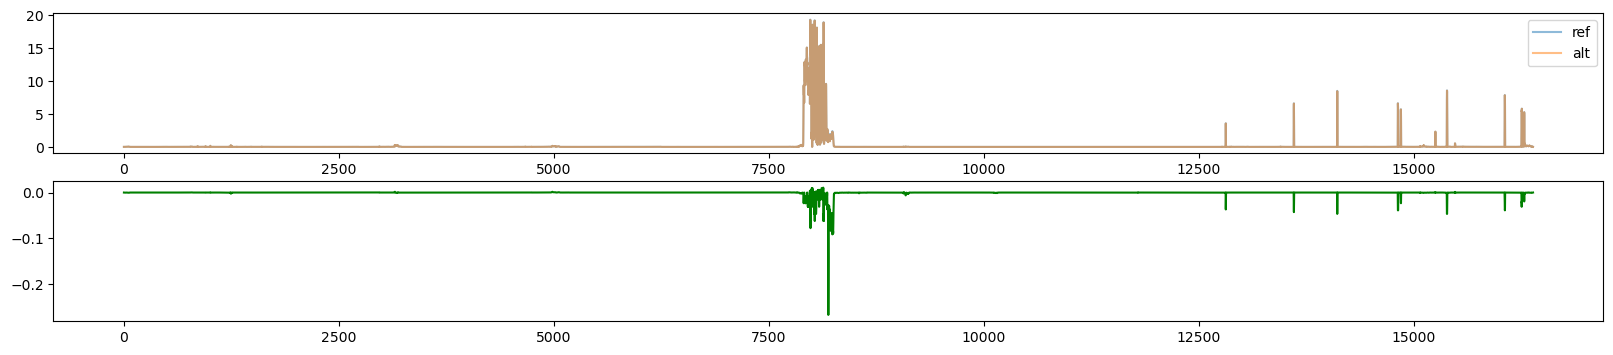

In [13]:
ti = 6364
fig, axs = plt.subplots(2, figsize=(20,4))
axs[0].plot(snp_ref[:,ti], alpha=0.5, label='ref')
axs[0].plot(snp_alt[:,ti], alpha=0.5, label='alt')
axs[0].legend()
axs[1].plot(snp_alt[:,ti]-snp_ref[:,ti], c='green')

## ISM

In [36]:
snp_dir = f'{rs_id}_out'

ism_base = f'{snp_dir}/ism'

with open(f'{ism_base}.sb', 'w') as ism_open:
    print(f'#!/bin/bash\n', file=ism_open)
    print(f'#SBATCH -p gpu', file=ism_open)
    print(f'#SBATCH --gres=gpu:nvidia_geforce_gtx_1080_ti:1', file=ism_open)
    print(f'#SBATCH -n 1', file=ism_open)
    print(f'#SBATCH -c 4', file=ism_open)
    print(f'#SBATCH -J {rs_id}', file=ism_open)
    print(f'#SBATCH -o {ism_base}.out', file=ism_open)
    print(f'#SBATCH -e {ism_base}.err', file=ism_open)
    print(f'#SBATCH --time 12:0:0', file=ism_open)
    print(f'#SBATCH --mem 30000', file=ism_open)
    print(f'\n. /home/drk/anaconda3/etc/profile.d/conda.sh', file=ism_open)
    print(f'conda activate tf13', file=ism_open)
    
    ism_cmd = f'hound_ism_snp.py -l 120 --rc'
    ism_cmd += f' -f {fasta_file}'
    ism_cmd += f' -o {ism_base}_out'
    ism_cmd += f' --stats logSUM,logD2'
    ism_cmd += f' -t {targets_file}'
    ism_cmd += f' {params_file} {model_file} {vcf_file}'
    print(ism_cmd, file=ism_open)    

In [37]:
! sbatch {ism_base}.sb

/bin/bash: /home/drk/anaconda3/envs/tf13/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Submitted batch job 3455259


In [16]:
def plot_logo(scores, seq_1hot, viz_len=None, ymin=-np.inf, ymax=np.inf):
    if viz_len is not None and viz_len < seq_1hot.shape[0]:
        mid_pos = seq_1hot.shape[0]//2
        viz_start = mid_pos - viz_len//2
        viz_end = viz_start + viz_len
        scores = scores[viz_start:viz_end]
        seq_1hot = seq_1hot[viz_start:viz_end]
    scores = np.clip(scores, ymin, ymax)
    
    fig, axs = plt.subplots(2, 1, figsize=(30,3.5))
    seq_df = pd.DataFrame(seq_1hot*scores, columns=['A','C','G','T'])
    seq_logo = logomaker.Logo(seq_df, ax=axs[0])
    if not np.isinf(ymin):
        seq_logo.ax.set_ylim(bottom=ymin)
    if not np.isinf(ymax):
        seq_logo.ax.set_ylim(top=ymax)
        
    sns.heatmap(scores.T, center=0, cbar=False, ax=axs[1])
    axs[1].set_yticklabels('ACGT')

In [47]:
ism_h5_file = f'{ism_base}_out/scores.h5'
with h5py.File(ism_h5_file, 'r') as ism_h5:
    seq_1hot_ref = ism_h5['seqs'][0]
    seq_1hot_alt = ism_h5['seqs'][1]
    ref_sum = ism_h5['logSUM'][0]
    alt_sum = ism_h5['logSUM'][1]
    ref_d2 = ism_h5['logD2'][0]
    alt_d2 = ism_h5['logD2'][1]
seq_1hot_ref.shape, ref_sum.shape, ref_d2.shape

((120, 4), (120, 4, 6385), (120, 4, 6385))

In [56]:
ti = 6331
ref_sum_ti = ref_sum[...,ti].mean(axis=-1, dtype='float32')
alt_sum_ti = alt_sum[...,ti].mean(axis=-1, dtype='float32')
ref_d2_ti = ref_d2[...,ti].mean(axis=-1, dtype='float32')
alt_d2_ti = alt_d2[...,ti].mean(axis=-1, dtype='float32')

# mean normalize
ref_sum_ti = ref_sum_ti - ref_sum_ti.mean(axis=-1, keepdims=True)
alt_sum_ti = alt_sum_ti - alt_sum_ti.mean(axis=-1, keepdims=True)
ref_d2_ti = ref_d2_ti.mean(axis=-1, keepdims=True) - ref_d2_ti
alt_d2_ti = alt_d2_ti.mean(axis=-1, keepdims=True) - alt_d2_ti

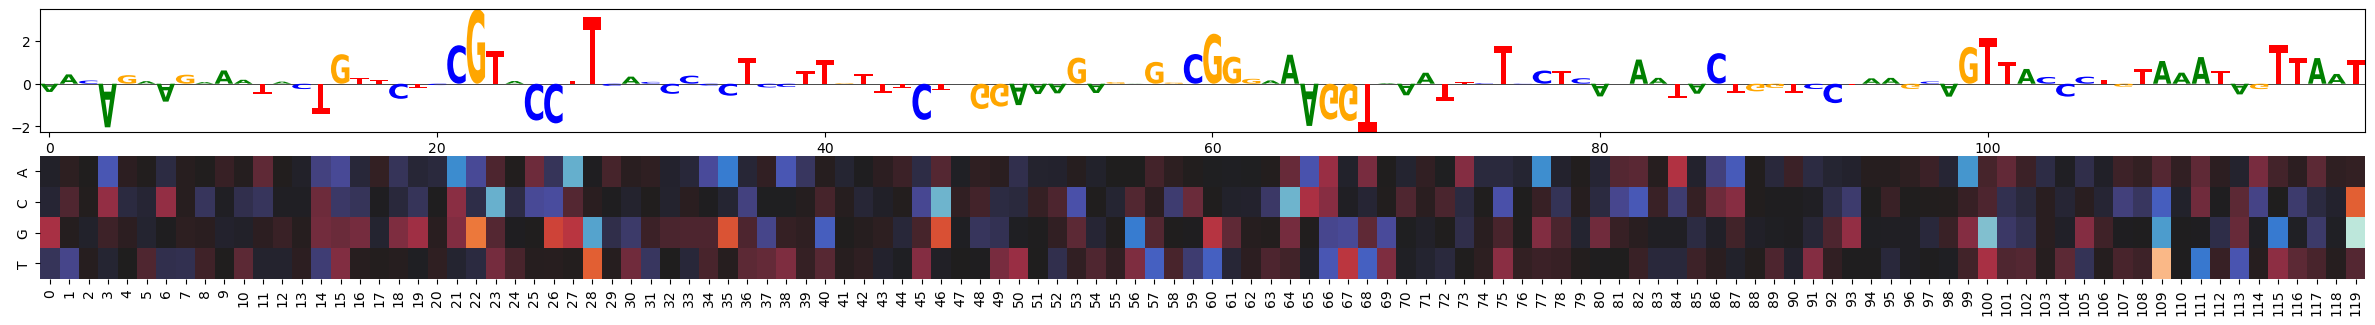

In [57]:
plot_logo(ref_sum_ti, seq_1hot_ref, 160) # , ymin=-4, ymax=9)

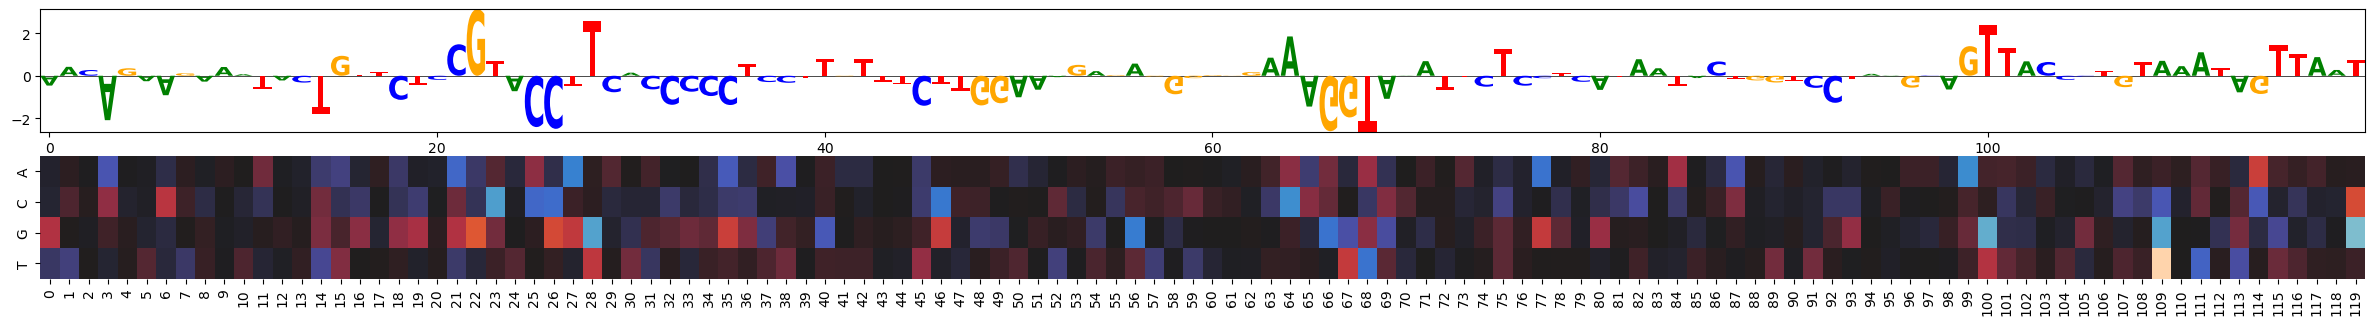

In [58]:
plot_logo(alt_sum_ti, seq_1hot_alt, 160) # , ymin=-4, ymax=9)

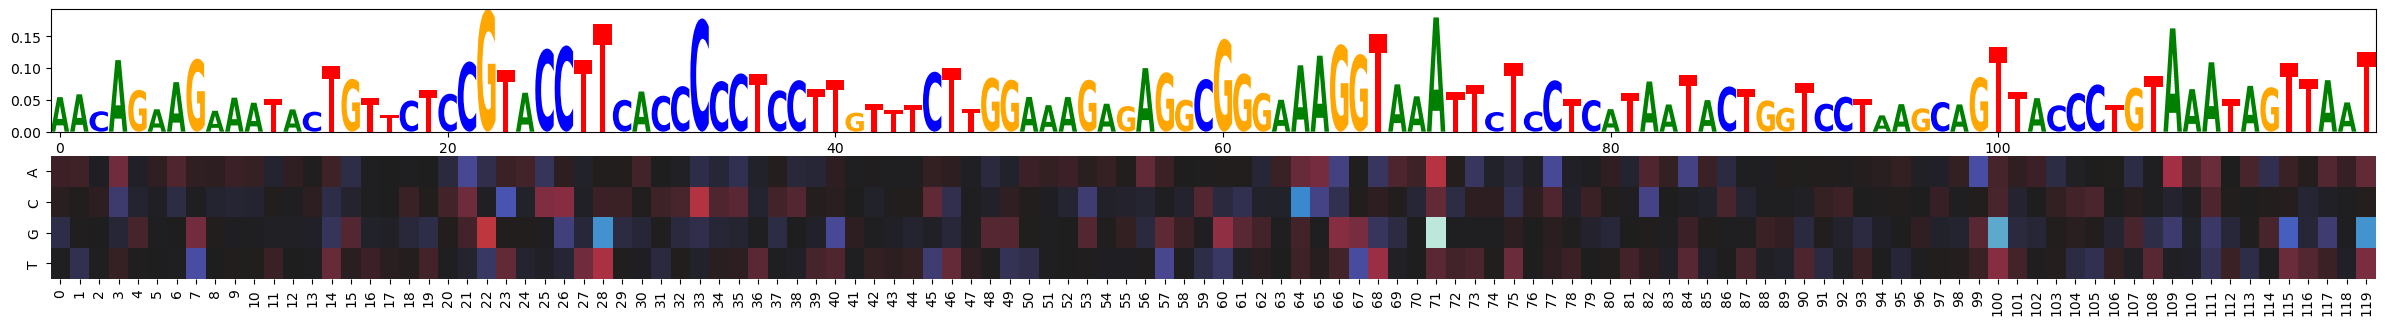

In [59]:
plot_logo(ref_d2_ti, seq_1hot_ref, 160) # , ymin=-4, ymax=9)

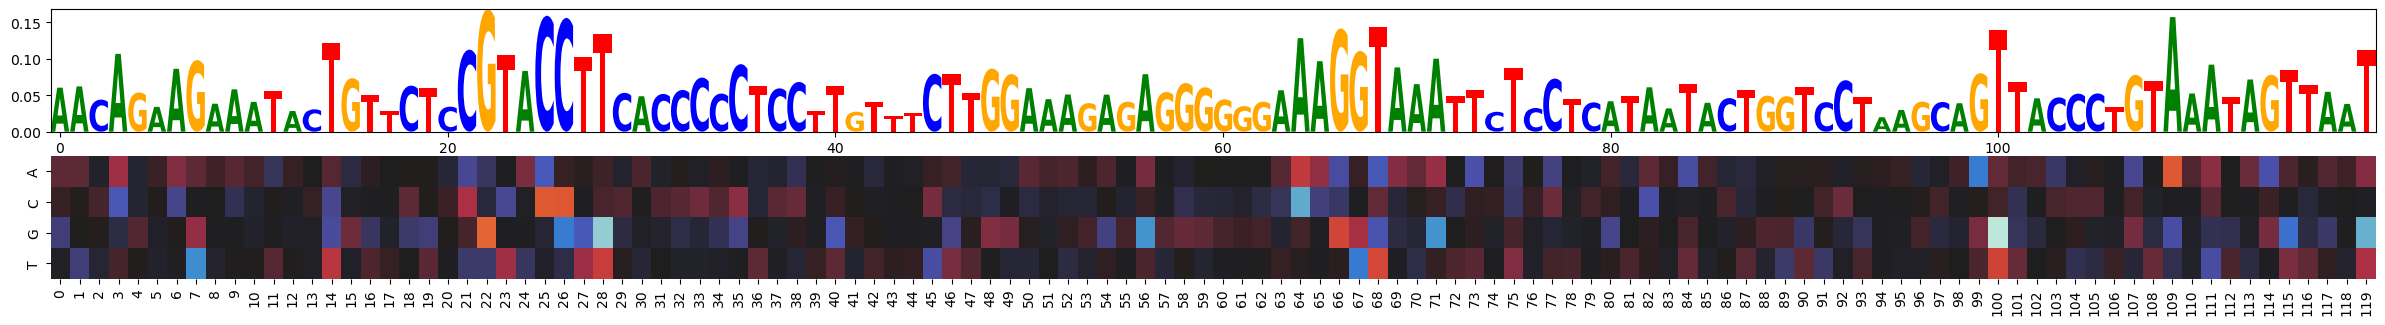

In [62]:
plot_logo(alt_d2_ti, seq_1hot_alt, 160) # , ymin=-4, ymax=9)